## Fichier pour l'optimisation des bandes de Bollinguer 

#### Import des Fichiers nécéssaires 

In [127]:
# Le nécéssaire pour les algorithmes génétiques 
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
#fichier sujet de l'optimisation 
from _bollinger_bands import BollingerBands
from _bollinger_bands import BollingerBands
#Data Analysis 
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [167]:
data=pd.read_excel("Data_MASI.xlsx",parse_dates=True, index_col=0)
data.drop([data.index[0],data.index[1735]],inplace=True)
data
data.drop(data.index[0:1735], inplace=True)

In [168]:
data

,Close,High,Low,Open,variation,Volume_Marche_Bloc,Volume_Marche_Central
Date,,,,,,,
2002-01-07,3437.360000,3437.360000,3437.360000,3437.360000,-0.001145,0.00,1.489486e+08
2002-01-08,3413.320000,3413.320000,3413.320000,3413.320000,-0.006994,0.00,1.368271e+07
2002-01-09,3415.700000,3415.700000,3415.700000,3415.700000,0.000697,590000.00,1.744494e+07
2002-01-10,3428.630000,3428.630000,3428.630000,3428.630000,0.003785,0.00,2.381091e+07
2002-01-14,3420.440000,3420.440000,3420.440000,3420.440000,-0.002389,364172.00,2.733116e+07
...,...,...,...,...,...,...,...
2020-07-10,10148.910156,10220.610352,10138.320312,10219.169922,-0.006875,0.00,4.582413e+07
2020-07-13,10177.009766,10212.469727,10147.049805,10148.910156,0.002769,0.00,5.906911e+07
2020-07-14,10159.839844,10174.139648,10132.669922,10165.450195,-0.001687,0.00,9.065745e+07


In [169]:
df=data["Close"]
high=data["High"]
low=data["Low"]
data["Volume"]=data["Volume_Marche_Bloc"].loc["2002-01-01":] + data["Volume_Marche_Central"].loc["2002-01-01":]

In [170]:
data

,Close,High,Low,Open,variation,Volume_Marche_Bloc,Volume_Marche_Central,Volume
Date,,,,,,,,
2002-01-07,3437.360000,3437.360000,3437.360000,3437.360000,-0.001145,0.00,1.489486e+08,1.489486e+08
2002-01-08,3413.320000,3413.320000,3413.320000,3413.320000,-0.006994,0.00,1.368271e+07,1.368271e+07
2002-01-09,3415.700000,3415.700000,3415.700000,3415.700000,0.000697,590000.00,1.744494e+07,1.803494e+07
2002-01-10,3428.630000,3428.630000,3428.630000,3428.630000,0.003785,0.00,2.381091e+07,2.381091e+07
2002-01-14,3420.440000,3420.440000,3420.440000,3420.440000,-0.002389,364172.00,2.733116e+07,2.769533e+07
...,...,...,...,...,...,...,...,...
2020-07-10,10148.910156,10220.610352,10138.320312,10219.169922,-0.006875,0.00,4.582413e+07,4.582413e+07
2020-07-13,10177.009766,10212.469727,10147.049805,10148.910156,0.002769,0.00,5.906911e+07,5.906911e+07
2020-07-14,10159.839844,10174.139648,10132.669922,10165.450195,-0.001687,0.00,9.065745e+07,9.065745e+07


## Fonction

In [171]:
premier=0 

In [172]:
def GeneticAlgo(dim,obj_func,MAX_GENERATIONS,BOUND_LOW,BOUND_UP,POPULATION_SIZE=40,P_CROSSOVER = 0.9,P_MUTATION = 0.1):
	global premier
	ONE_MAX_LENGTH=dim
	HALL_OF_FAME_SIZE = 5
	CROWDING_FACTOR=20
	RANDOM_SEED = 40
	random.seed(RANDOM_SEED)
	if premier> 0 :
		del creator.FitnessMax
		del creator.Individual
	premier=premier+1
	toolbox = base.Toolbox()
	toolbox.register("Num", random.randint, BOUND_LOW, BOUND_UP)
	creator.create("FitnessMax", base.Fitness, weights=(1.0,))
	creator.create("Individual", list, fitness=creator.FitnessMax)
	toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.Num, ONE_MAX_LENGTH)
	toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)
	toolbox.register("evaluate", obj_func)
	toolbox.register("select", tools.selTournament, tournsize=3)
	toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR)
	toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR, indpb=0.20)
	def main():
		population = toolbox.populationCreator(n=POPULATION_SIZE)
		stats = tools.Statistics(lambda ind: ind.fitness.values)
		stats.register("max", np.max)
		stats.register("avg", np.mean)
		hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
		population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,ngen=MAX_GENERATIONS
			, stats=stats, halloffame=hof, verbose=True)
		print("Hall of Fame Individuals = ", *hof.items, sep="\n")
		print("Best Ever Individual = ", [ int(i) for i in hof.items[0]])
		maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")
		sns.set_style("whitegrid")
		plt.plot(maxFitnessValues, color='red')
		plt.plot(meanFitnessValues, color='green')
		plt.xlabel('Génération')
		plt.ylabel('Max / Moyenne Fitness')
		plt.title('Max et Moyenne de  Fitness opar générations')
		plt.show()
	main()

### Coût des transactions

In [173]:

ti=0.0022
fr=0.0011
cb=0.0011
taux=ti+fr+cb

### Fonction Objective 

In [174]:
def pmv(close,signal):
	"""
		La Plus-ou-moins-value
	"""
	close=np.array(close)
	signal=np.array(signal.fillna(0))
	qt=signal.cumsum()
	achat= np.where(signal>=1,1,0)
	PDR=[]
	for t in range(len(close)):
		p=(close[:t+1]*achat[:t+1]).sum()
		if achat[:t+1].sum()==0 :
			val=0
		else :
			p=p/(achat[:t+1].sum())
			val=qt[t]*p 
		PDR.append(val)
	PMV_lat=close*qt-PDR
	PMV_re=[0]
	for i in range(1,len(close)):
		vl=PDR[i]-PDR[i-1]+PMV_re[i-1]-close[i]*signal[i]
		PMV_re.append(vl)
	PMV=PMV_lat+PMV_re
	return PMV

In [175]:
def adjustsignal(signal):
	sig=[]
	qtite=0
	for i in signal:
		if i > 0 :
			sig.append(i)
			qtite+=1
            
		elif i < 0:
			if qtite >= abs(i) :
				sig.append(i)
				qtite+=-i
			else:
				sig.append(0)
		else:
			sig.append(0)
	return sig

### Comment manipuler le fichier des bandes de bollinguer 

In [176]:
#Instanciation de la classe avec le jeu de donnée dont on dispose 
BB=BollingerBands(data)

In [177]:
#Exemple de calcul avec deux paramètre choisies au pif 
BB._calculateTi(period=12,std_number=4)

,middle_band,upper_band,lower_band
Date,,,
2002-01-07,NaN,NaN,NaN
2002-01-08,NaN,NaN,NaN
2002-01-09,NaN,NaN,NaN
2002-01-10,NaN,NaN,NaN
2002-01-14,NaN,NaN,NaN
...,...,...,...
2020-07-10,10180.825114,10352.1423,10009.5079
2020-07-13,10176.019287,10334.5512,10017.4874
2020-07-14,10179.840088,10321.6769,10038.0033


### Fonction Objectif adaptée au Bandes de Bollinguer 

In [178]:
def obj_bollinger(period):
    global std_number 
    period=int(period[0])
    signal=pd.DataFrame(index=df.index)
    signal["compa"]=np.nan
    signal["compa2"]=np.nan
    bb=BB._calculateTi(period,std_number)[["upper_band","lower_band"]]
    #bb=at.bollinger(df,n,k)[["BBDOWN","BBUP"]]
    signal["compa"][period:] = np.where( (df[period:] > bb["upper_band"][period:] ) ,1,0)
    signal["compa2"][period:] = np.where( (df[period:] < bb["lower_band"][period:] ) ,4,2)
    signal["signal"]=signal["compa"].diff()
    signal["signal2"]=signal["compa2"].diff()
    sig=np.where(signal["signal"]==1,-1,0)+np.where(signal["signal2"]==2,1,0)
    sig=adjustsignal(sig)
    sig=pd.Series(sig, index=df.index)
    cours=df*(1+taux*sig)
    pmval=pmv(cours,sig)
    return pmval.max(),

c:\Users\pc\anaconda3\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\pc\anaconda3\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	max    	avg    
0  	40    	23928.3	5191.03
1  	36    	23928.3	11227.5
2  	40    	23928.3	17113  
3  	37    	23928.3	21373  
4  	38    	23928.3	22090.2
5  	33    	23928.3	23885.6
Hall of Fame Individuals = 
[21.161145788046863]
[21.391450146182066]
[21.16042663211538]
[21.032796705588474]
[21]
Best Ever Individual =  [21]


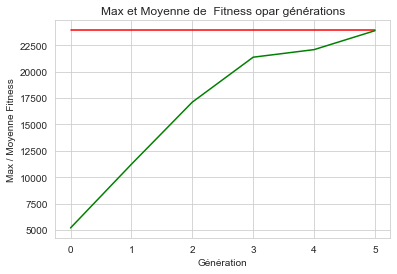

In [179]:
std_number=3 
GeneticAlgo(1,obj_bollinger,5,20,60)

gen	nevals	max    	avg    
0  	40    	11762.6	1475.56
1  	36    	11762.6	3121.23
2  	38    	11762.6	4809.33
3  	35    	11762.6	7428.86
4  	36    	11762.6	9238.71
5  	34    	11762.6	11145.8
Hall of Fame Individuals = 
[39.297299763339794]
[39.055720003175004]
[39.08070285752669]
[39.01888446989152]
[39]
Best Ever Individual =  [39]


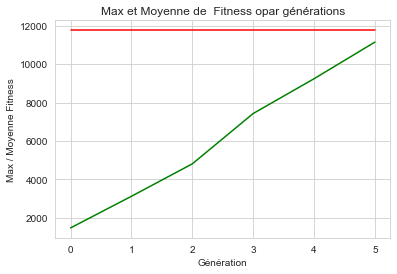

In [180]:

std_number=2.5
GeneticAlgo(1,obj_bollinger,5,20,60)

gen	nevals	max    	avg   
0  	40    	19448.9	3497.9
1  	30    	19448.9	10588.1
2  	40    	19448.9	17286.7
3  	36    	19448.9	19166.7
4  	38    	19448.9	19378.3
5  	40    	19448.9	19448.9
6  	36    	19448.9	19448.9
7  	38    	19448.9	19307.8
8  	38    	19448.9	19307.8
9  	38    	19448.9	19378.3
10 	36    	19448.9	19025.5
Hall of Fame Individuals = 
[19.001413831767806]
[19.00025622967049]
[19.017155806937645]
[19.017412036608135]
[19]
Best Ever Individual =  [19]


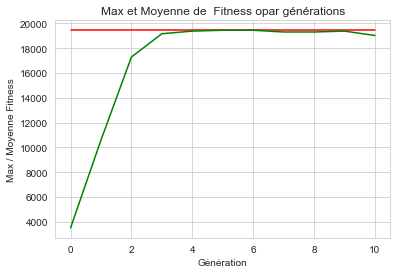

In [181]:
k=2
GeneticAlgo(1,obj_bollinger,10,18,35)

### BackTesting 

In [184]:
opt=BollingerBands(data)
std=BollingerBands(data)
std._calculateTi(period=20,std_number=2)

,middle_band,upper_band,lower_band
Date,,,
2002-01-07,NaN,NaN,NaN
2002-01-08,NaN,NaN,NaN
2002-01-09,NaN,NaN,NaN
2002-01-10,NaN,NaN,NaN
2002-01-14,NaN,NaN,NaN
...,...,...,...
2020-07-10,10223.934570,10443.4116,10004.4575
2020-07-13,10231.771045,10431.9457,10031.5963
2020-07-14,10235.531055,10427.1522,10043.9099


In [191]:

opt._calculateTi(period=19,std_number=2)

,middle_band,upper_band,lower_band
Date,,,
2002-01-07,NaN,NaN,NaN
2002-01-08,NaN,NaN,NaN
2002-01-09,NaN,NaN,NaN
2002-01-10,NaN,NaN,NaN
2002-01-14,NaN,NaN,NaN
...,...,...,...
2009-05-05,10733.127895,11098.0396,10368.2162
2009-05-06,10750.494211,11123.9147,10377.0738
2009-05-07,10771.321579,11147.8286,10394.8146


In [148]:
data 

,close,high,low,open,variation,volume_marche_bloc,volume_marche_central,volume
Date,,,,,,,,
1995-01-03,2109.160000,NaN,NaN,NaN,-0.003138,NaN,NaN,NaN
1995-01-04,2108.430000,NaN,NaN,NaN,-0.000346,NaN,NaN,NaN
1995-01-05,2109.600000,NaN,NaN,NaN,0.000555,NaN,NaN,NaN
1995-01-06,2108.760000,NaN,NaN,NaN,-0.000398,NaN,NaN,NaN
1995-01-09,2113.980000,NaN,NaN,NaN,0.002475,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-07-10,10148.910156,10220.610352,10138.320312,10219.169922,-0.006875,0.00,45824131.24,45824131.24
2020-07-13,10177.009766,10212.469727,10147.049805,10148.910156,0.002769,0.00,59069111.96,59069111.96
2020-07-14,10159.839844,10174.139648,10132.669922,10165.450195,-0.001687,0.00,90657445.98,90657445.98


In [185]:
df=pd.DataFrame(data.close)


Simulation Data:
            signal open_trading_action   stock_value exposure portfolio_value  \
Date                                                                           
2002-01-07   hold                none       3437.36      0.0             0.0   
2002-01-08   hold                none       3413.32      0.0             0.0   
2002-01-09   hold                none        3415.7      0.0             0.0   
2002-01-10   hold                none       3428.63      0.0             0.0   
2002-01-14   hold                none       3420.44      0.0             0.0   
...           ...                 ...           ...      ...             ...   
2020-07-10   hold                none  10148.910156      0.0             0.0   
2020-07-13   hold                none  10177.009766      0.0             0.0   
2020-07-14   hold                none  10159.839844      0.0             0.0   
2020-07-15   hold                none   10261.44043      0.0             0.0   
2020-07-16   hold    

,signal,open_trading_action,stock_value,exposure,portfolio_value,earnings,balance
Date,,,,,,,
2002-01-07,hold,none,3437.36,0.0,0.0,0.0,0.0
2002-01-08,hold,none,3413.32,0.0,0.0,0.0,0.0
2002-01-09,hold,none,3415.7,0.0,0.0,0.0,0.0
2002-01-10,hold,none,3428.63,0.0,0.0,0.0,0.0
2002-01-14,hold,none,3420.44,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2020-07-10,hold,none,10148.910156,0.0,0.0,0.0,0.0
2020-07-13,hold,none,10177.009766,0.0,0.0,0.0,0.0
2020-07-14,hold,none,10159.839844,0.0,0.0,0.0,0.0


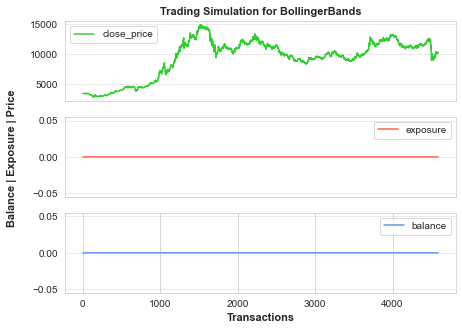

In [186]:
simulation_data, simulation_statistics,simulation_graph = \
opt.getTiSimulation(close_values=df, max_exposure=None,short_exposure_factor=1.5)

print('\nSimulation Data:\n', simulation_data)
print('\nSimulation Statistics:\n', simulation_statistics)

simulation_data=pd.DataFrame(simulation_data)
simulation_data


Simulation Data:
            signal open_trading_action   stock_value exposure portfolio_value  \
Date                                                                           
2002-01-07   hold                none       3437.36      0.0             0.0   
2002-01-08   hold                none       3413.32      0.0             0.0   
2002-01-09   hold                none        3415.7      0.0             0.0   
2002-01-10   hold                none       3428.63      0.0             0.0   
2002-01-14   hold                none       3420.44      0.0             0.0   
...           ...                 ...           ...      ...             ...   
2020-07-10   hold                none  10148.910156      0.0             0.0   
2020-07-13   hold                none  10177.009766      0.0             0.0   
2020-07-14   hold                none  10159.839844      0.0             0.0   
2020-07-15   hold                none   10261.44043      0.0             0.0   
2020-07-16   hold    

,signal,open_trading_action,stock_value,exposure,portfolio_value,earnings,balance
Date,,,,,,,
2002-01-07,hold,none,3437.36,0.0,0.0,0.0,0.0
2002-01-08,hold,none,3413.32,0.0,0.0,0.0,0.0
2002-01-09,hold,none,3415.7,0.0,0.0,0.0,0.0
2002-01-10,hold,none,3428.63,0.0,0.0,0.0,0.0
2002-01-14,hold,none,3420.44,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2020-07-10,hold,none,10148.910156,0.0,0.0,0.0,0.0
2020-07-13,hold,none,10177.009766,0.0,0.0,0.0,0.0
2020-07-14,hold,none,10159.839844,0.0,0.0,0.0,0.0


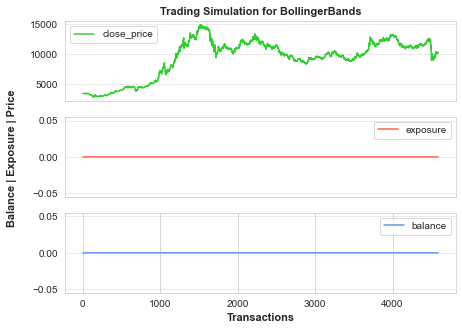

In [188]:
simulation_data, simulation_statistics,simulation_graph = \
std.getTiSimulation(close_values=df, max_exposure=None,short_exposure_factor=1.5)

print('\nSimulation Data:\n', simulation_data)
print('\nSimulation Statistics:\n', simulation_statistics)

simulation_data=pd.DataFrame(simulation_data)
simulation_data